### Data Exploration
- We've scraped football data from fbref website and also we added 2 new columns generated (Home Team Goal Difference and Away Team Goal Difference)

In [1705]:
!pip install ipykernel matplotlib scikit-learn pandas numpy seaborn requests xgboost

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# List of csv files (datasets)
csv_files = ['matches-2023-2024.csv', 'matches-2022-2023.csv', 'matches-2021-2022.csv']

df_list = [pd.read_csv(file) for file in csv_files]
matches = pd.concat(df_list, ignore_index=True)
# matches = pd.read_csv('matches-2023-2024.csv')

df = matches.copy()

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Sort dataframe by Date in ascending order
df = df.sort_values(by="Date").reset_index(drop=True)
df.drop(columns=['Time'], inplace=True)

df.tail()

,Date,Home Team,XGH,Away Team,XGA,Score,FTHG,FTAG,HTGDIFF,ATGDIFF,Result,Referee,STH,STA
1135,2024-05-19,Sheffield Utd,1.0,Tottenham,3.1,0–3,0,3,-3,3,2,Andy Madley,1,9
1136,2024-05-19,Luton Town,2.0,Fulham,1.1,2–4,2,4,-2,2,2,Matt Donohue,5,8
1137,2024-05-19,Liverpool,4.5,Wolves,0.5,2–0,2,0,2,-2,1,Chris Kavanagh,13,2
1138,2024-05-19,Manchester City,1.9,West Ham,0.4,3–1,3,1,2,-2,1,John Brooks,12,2
1139,2024-05-19,Crystal Palace,2.5,Aston Villa,0.9,5–0,5,0,5,-5,1,Darren Bond,9,2


In [1706]:
df.head()

,Date,Home Team,XGH,Away Team,XGA,Score,FTHG,FTAG,HTGDIFF,ATGDIFF,Result,Referee,STH,STA
0,2021-08-13,Brentford,1.2,Arsenal,1.3,2–0,2,0,2,-2,1,Michael Oliver,3,4
1,2021-08-14,Norwich City,1.4,Liverpool,1.6,0–3,0,3,-3,3,2,Andre Marriner,3,6
2,2021-08-14,Manchester Utd,1.5,Leeds United,0.5,5–1,5,1,4,-4,1,Paul Tierney,8,3
3,2021-08-14,Leicester City,0.5,Wolves,1.3,1–0,1,0,1,-1,1,Craig Pawson,5,3
4,2021-08-14,Burnley,1.5,Brighton,1.0,1–2,1,2,-1,1,2,David Coote,3,6


In [1707]:
# Function to calculate average goal difference for home and away teams
def avg_stats(df, avg_xg_col, team, xg_col, matches):
    all_teams = df[team].unique()
    
    df[avg_xg_col] = 0.0  # Ensure it's float to store rolling averages

    for t in all_teams:
        df_team = df[df[team] == t].copy()  # Filter by team
        df_team[avg_xg_col] = df_team[xg_col].rolling(window=matches, min_periods=1).median().shift(1).fillna(0)
        
        df.update(df_team[[avg_xg_col]])

# Apply function for Home and Away teams
avg_stats(df, "AVGHGD", "Home Team", "HTGDIFF", 15)
avg_stats(df, "AVGAGD", "Away Team", "ATGDIFF", 15)

# Apply function for Home and Away teams
avg_stats(df, "AVGHXG", "Home Team", "XGH", 10)
avg_stats(df, "AVGAXG", "Away Team", "XGA", 10)

# Apply function for shoots on target last 
avg_stats(df, "AVGSTH", "Home Team", "STH", 10)
avg_stats(df, "AVGSTA", "Away Team", "STA", 10)

In [1708]:
# Test the function above it's working as expected

liverpool_games = df[df["Away Team"] == "Liverpool"][["Date", "Away Team", "ATGDIFF", "AVGAGD"]]
print(liverpool_games)
liverpool_past_games = liverpool_games.iloc[0:5]["ATGDIFF"]
print("Liverpool's Past ATGDIFF:\n", liverpool_past_games)

expected_median = liverpool_past_games.median()
print("Expected Median:", expected_median)

correct_index = liverpool_games.index[5]  # 6th match index in the original df
computed_avgagd = df.loc[correct_index, "AVGAGD"]
print("Computed AVGAGD:", computed_avgagd)


           Date  Away Team  ATGDIFF  AVGAGD
1    2021-08-14  Liverpool        3     0.0
38   2021-09-12  Liverpool        3     3.0
51   2021-09-25  Liverpool        0     3.0
74   2021-10-16  Liverpool        5     3.0
88   2021-10-24  Liverpool        5     3.0
106  2021-11-07  Liverpool       -1     3.0
136  2021-12-01  Liverpool        3     3.0
139  2021-12-04  Liverpool        1     3.0
166  2021-12-19  Liverpool        0     3.0
179  2021-12-28  Liverpool       -1     3.0
187  2022-01-02  Liverpool        0     2.0
210  2022-01-23  Liverpool        2     1.0
230  2022-02-13  Liverpool        1     1.5
272  2022-03-12  Liverpool        2     1.0
282  2022-03-16  Liverpool        2     1.5
305  2022-04-10  Liverpool        0     2.0
334  2022-04-30  Liverpool        1     1.0
352  2022-05-10  Liverpool        1     1.0
366  2022-05-17  Liverpool        1     1.0
385  2022-08-06  Liverpool        0     1.0
409  2022-08-22  Liverpool       -1     1.0
436  2022-09-03  Liverpool      

In [1709]:
# def head_to_head_form(df):
#     # Create a column for head-to-head result form
#     df['HTH_Form'] = ""  # Initialize with empty strings
    
#     # Temporarily convert "Result" column to numeric (convert to 1, 0, -1 for win, draw, loss)
#     temp_result = pd.to_numeric(df["Result"], errors="coerce")  # Convert to numeric temporarily
    
#     for idx, row in df.iterrows():
#         home_team = row["Home Team"]
#         away_team = row["Away Team"]
        
#         # Filter past matches between the two teams (regardless of home/away)
#         past_matches = df[((df["Home Team"] == home_team) & (df["Away Team"] == away_team)) | 
#                           ((df["Home Team"] == away_team) & (df["Away Team"] == home_team))]

#         # Get the result of the last 5 matches
#         past_matches = past_matches.tail(5)  # Get the last 5 matches
        
#         # Create the form string for the last 5 matches
#         form = ""
#         for _, match in past_matches.iterrows():
#             result_value = int(temp_result[match.name]) if not pd.isna(temp_result[match.name]) else 0
            
#             # Convert result into W, L, D
#             if result_value == 1:
#                 form += "W"
#             elif result_value == 0:
#                 form += "D"
#             elif result_value == -1:
#                 form += "L"
        
#         # Update the form column
#         df.at[idx, "HTH_Form"] = form
    
#     return df

# # Apply the head-to-head form calculation
# df = head_to_head_form(df)


In [1710]:
df.head(50)

,Date,Home Team,XGH,Away Team,XGA,Score,FTHG,FTAG,HTGDIFF,ATGDIFF,Result,Referee,STH,STA,AVGHGD,AVGAGD,AVGHXG,AVGAXG,AVGSTH,AVGSTA
0,2021-08-13,Brentford,1.2,Arsenal,1.3,2–0,2,0,2,-2,1,Michael Oliver,3,4,0.0,0.0,0.00,0.00,0.0,0.0
1,2021-08-14,Norwich City,1.4,Liverpool,1.6,0–3,0,3,-3,3,2,Andre Marriner,3,6,0.0,0.0,0.00,0.00,0.0,0.0
2,2021-08-14,Manchester Utd,1.5,Leeds United,0.5,5–1,5,1,4,-4,1,Paul Tierney,8,3,0.0,0.0,0.00,0.00,0.0,0.0
3,2021-08-14,Leicester City,0.5,Wolves,1.3,1–0,1,0,1,-1,1,Craig Pawson,5,3,0.0,0.0,0.00,0.00,0.0,0.0
4,2021-08-14,Burnley,1.5,Brighton,1.0,1–2,1,2,-1,1,2,David Coote,3,6,0.0,0.0,0.00,0.00,0.0,0.0
5,2021-08-14,Chelsea,0.7,Crystal Palace,0.2,3–0,3,0,3,-3,1,Jonathan Moss,6,1,0.0,0.0,0.00,0.00,0.0,0.0
6,2021-08-14,Watford,1.2,Aston Villa,1.2,3–2,3,2,1,-1,1,Mike Dean,7,1,0.0,0.0,0.00,0.00,0.0,0.0
7,2021-08-14,Everton,2.4,Southampton,0.8,3–1,3,1,2,-2,1,Andy Madley,6,3,0.0,0.0,0.00,0.00,0.0,0.0
8,2021-08-15,Newcastle Utd,1.8,West Ham,2.7,2–4,2,4,-2,2,2,Martin Atkinson,3,7,0.0,0.0,0.00,0.00,0.0,0.0
9,2021-08-15,Tottenham,1.0,Manchester City,1.8,1–0,1,0,1,-1,1,Anthony Taylor,2,4,0.0,0.0,0.00,0.00,0.0,0.0


In [1711]:
# Create separate label encoders
home_encoder = LabelEncoder()
away_encoder = LabelEncoder()
referee_encoder = LabelEncoder()

df["Home Team"] = home_encoder.fit_transform(df["Home Team"])
df["Away Team"] = away_encoder.fit_transform(df["Away Team"])
df["Referee"] = referee_encoder.fit_transform(df["Referee"])

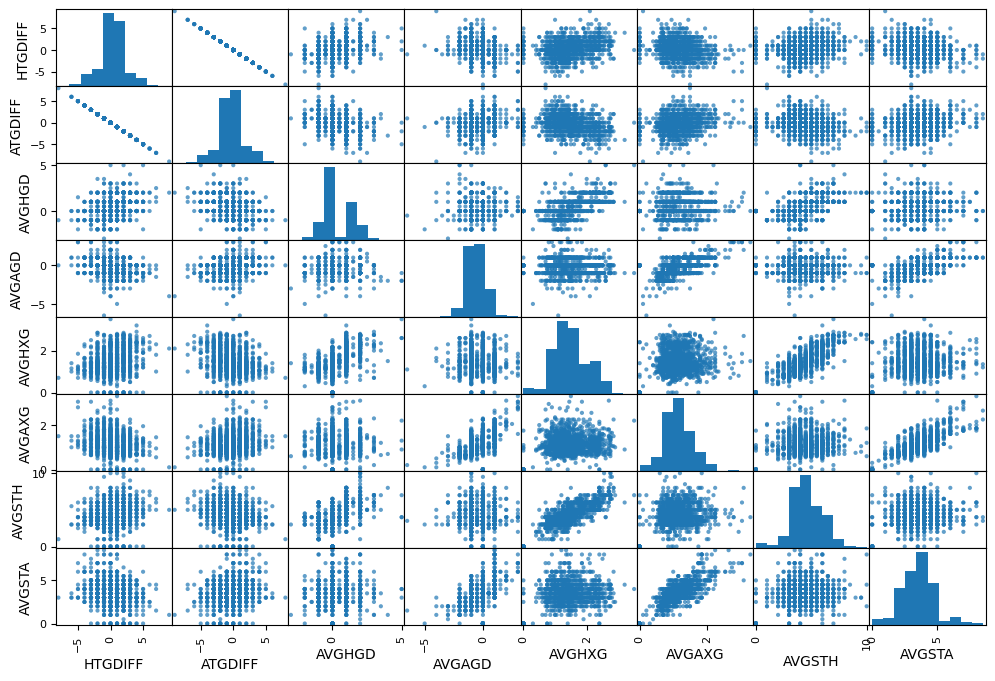

In [1712]:
# Visualize data
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

numerical_features = ["HTGDIFF", "ATGDIFF", "AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA"]
scatter_matrix(df[numerical_features], figsize=(12, 8), alpha=0.7)
plt.show()

In [1713]:
# Define the date cutoff for train/test split based on database
cutoff_date = "2024-01-01"

# Split data based on date
train_df = df[df["Date"] < cutoff_date]  # Train on matches before the cutoff
test_df = df[df["Date"] >= cutoff_date]  # Test on matches on or after the cutoff

# Define features and target variable
X_train = train_df[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "Home Team", "Away Team"]]
X_test = test_df[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "Home Team", "Away Team"]]

y_train = train_df["Result"]
y_test = test_df["Result"]

# Encode categorical target variable
result_encoder = LabelEncoder()
y_train_encoded = result_encoder.fit_transform(y_train)
y_test_encoded = result_encoder.transform(y_test)

# Ensure numeric columns are float64
X_train.loc[:, ["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA"]] = X_train[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA"]].astype(float)
X_test.loc[:, ["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA"]] = X_test[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA"]].astype(float)

scaler = StandardScaler()

X_train.loc[:, ["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA"]] = scaler.fit_transform(X_train[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA"]])
X_test.loc[:, ["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA"]] = scaler.transform(X_test[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA"]])

# Train a Random Forest model / XGBoost model
xgb_model = XGBClassifier(
    n_estimators=1000, 
    learning_rate=0.005, 
    colsample_bytree=0.5, 
    max_depth=4, 
    random_state=42
)

# xgb_model = RandomForestClassifier(
#     n_estimators=1000,  # Number of trees in the forest
#     max_depth=6,        # Maximum depth of each tree
#     min_samples_split=2, # Minimum samples to split a node
#     min_samples_leaf=1,  # Minimum samples in a leaf node
#     max_features='sqrt', # Number of features to consider for best split
#     random_state=42,
#     n_jobs=-1 # Use all available processors
# )

xgb_model.fit(X_train, y_train_encoded)

y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Model Accuracy:", accuracy)

# Decode predictions
y_pred_decoded = result_encoder.inverse_transform(y_pred)

# Create results dataframe
results_df = pd.DataFrame({
    "Home Team": test_df["Home Team"].values,
    "Away Team": test_df["Away Team"].values,
    "Result": y_test.values,
    "Predicted": y_pred_decoded
})

# Decode team names back from numerical values
results_df["Home Team"] = home_encoder.inverse_transform(results_df["Home Team"])
results_df["Away Team"] = away_encoder.inverse_transform(results_df["Away Team"])

print(results_df.head(10))


Model Accuracy: 0.5706521739130435
        Home Team        Away Team Result Predicted
0       Liverpool    Newcastle Utd      1         1
1        West Ham         Brighton      X         2
2         Burnley       Luton Town      X         2
3         Chelsea           Fulham      1         1
4   Newcastle Utd  Manchester City      2         2
5         Everton      Aston Villa      X         2
6  Manchester Utd        Tottenham      X         2
7       Brentford  Nott'ham Forest      1         1
8         Arsenal   Crystal Palace      1         1
9     Bournemouth        Liverpool      2         2


In [1714]:
# Feature Importance

importances = xgb_model.feature_importances_
feature_names = ["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "Home Team", "Away Team"]
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
print(feature_importance_df.sort_values(by="Importance", ascending=False))

     Feature  Importance
2     AVGHXG    0.150408
0     AVGHGD    0.143731
4     AVGSTH    0.130050
5     AVGSTA    0.122008
1     AVGAGD    0.116817
6  Home Team    0.114323
3     AVGAXG    0.111742
7  Away Team    0.110921


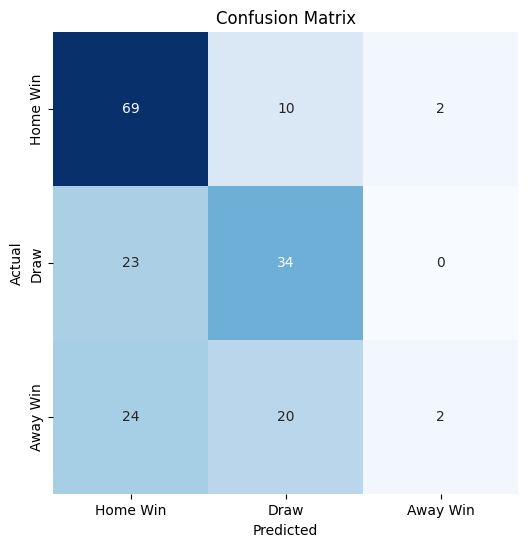

In [1715]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the results on the test set
y_pred = xgb_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Home Win', 'Draw', 'Away Win'], 
            yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

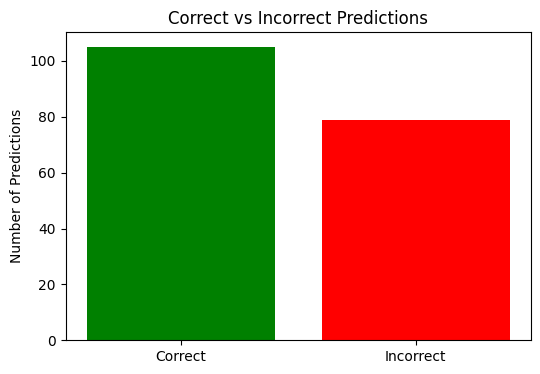

In [1716]:
#Accuracy Plot
import numpy as np

# Calculate correct and incorrect predictions
correct_predictions = np.sum(y_pred == y_test_encoded)
incorrect_predictions = np.sum(y_pred != y_test_encoded)

# Plot the proportion of correct vs. incorrect predictions
plt.figure(figsize=(6, 4))
plt.bar(['Correct', 'Incorrect'], [correct_predictions, incorrect_predictions], color=['green', 'red'])
plt.title('Correct vs Incorrect Predictions')
plt.ylabel('Number of Predictions')
plt.show()